In [1]:
import pandas as pd
from patsy import dmatrices
import matplotlib.pyplot as plt
import math as m
import numpy as np
import seaborn as sns
import statsmodels as sm
import statsmodels.api as sma
from statsmodels.compat import lzip
import statsmodels.stats.api as sms
from statsmodels.stats.outliers_influence import OLSInfluence
sns.set()
%matplotlib inline

In [2]:
data = pd.read_excel("Data/simulation_results_no_test_delays.xlsx", index_col = 0)

In [3]:
data

,R_0,hazard_rate_scale,contact_tracing_success_prob,contact_trace_delay_par,infection_detect_prob,global_contact_reduction,2_step_tracing,prob_has_trace_app,starting_infections,0,...,50,51,52,53,54,55,56,57,58,59
0,2.8,0.816518,0.876737,1.893839,0.286832,0.533694,False,0.794843,5000,5000,...,47353,47435,47512,47580,47653,47721,47765,47821,47883,47938.0
1,2.6,0.829253,0.816448,1.508859,0.405300,0.473357,False,0.438475,5000,5000,...,65460,66028,66563,67058,67561,67994,68396,68788,69165,69528.0
2,2.6,0.829253,0.839212,1.825112,0.520898,0.521115,True,0.911023,5000,5000,...,21210,21210,21210,21210,21210,21210,21210,21210,21210,21210.0
3,3.0,0.803782,0.880703,1.979270,0.544474,0.409727,False,0.228010,5000,5000,...,202359,207680,212884,218271,223680,229104,234488,240094,245718,251243.0
4,2.8,0.816518,0.855929,2.268005,0.334203,0.453197,False,0.937672,5000,5000,...,45728,45757,45777,45791,45808,45826,45832,45843,45850,45854.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,3.0,0.803782,0.924326,1.997851,0.486458,0.619114,False,0.490598,5000,5000,...,31518,31536,31547,31560,31577,31588,31598,31610,31624,31634.0
96,3.0,0.803782,0.765864,2.219247,0.658528,0.503811,True,0.874122,5000,5000,...,25240,25240,25240,25240,25240,25240,25240,25240,25240,25240.0
97,3.0,0.803782,0.738878,1.518774,0.513514,0.416812,False,0.608488,5000,5000,...,122736,124855,127008,128990,130996,132953,134947,136816,138809,140775.0
98,3.0,0.803782,0.943293,2.053858,0.526252,0.616928,True,0.487421,5000,5000,...,27006,27007,27008,27010,27011,27012,27013,27013,27013,27014.0


In [4]:
infection_counts = [str(i) for i in range(60)]
infection_counts = data[infection_counts]

Text(0.5, 1.0, 'Total Infected')

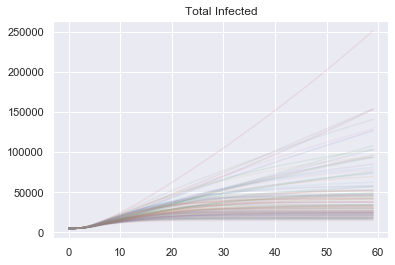

In [5]:
for _ in range(data.shape[0]):
    plt.plot(range(60), infection_counts.iloc[_], alpha = 0.1)
plt.title("Total Infected")

Text(0.5, 1.0, '$log_2$(Total Infected)')

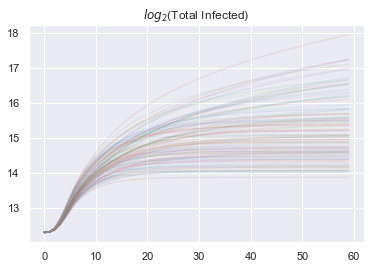

In [6]:
for _ in range(data.shape[0]):
    plt.plot(range(60), infection_counts.iloc[_].apply(lambda x: np.log2(x)), alpha = 0.1)
plt.title("$log_2$(Total Infected)")

Text(0.5, 1.0, 'Infection Incidence')

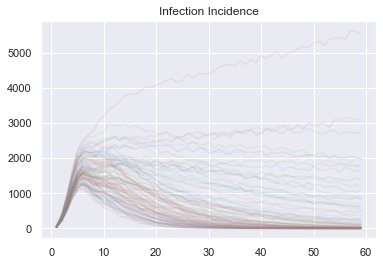

In [7]:
for _ in range(data.shape[0]):
    plt.plot(range(60), infection_counts.iloc[_].diff(1), alpha = 0.1)
plt.title("Infection Incidence")

Text(0.5, 1.0, 'Infection Incidence (14 epidemics)')

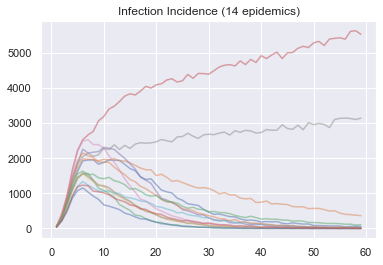

In [8]:
for _ in range(14):
    plt.plot(range(60), infection_counts.iloc[_].diff(1), alpha = 0.5)
plt.title("Infection Incidence (14 epidemics)")

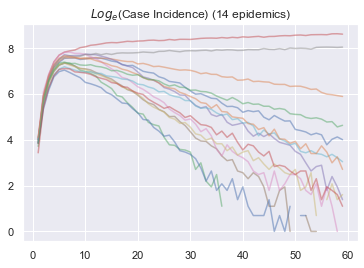

In [9]:
for _ in range(14):
    plt.plot(range(60), infection_counts.iloc[_].diff(1).apply(lambda x: np.log(x)), alpha = 0.5)
plt.title("$Log_e$(Case Incidence) (14 epidemics)")
plt.savefig("Figures/Log_case_incidence.png")

We can see the variance begins to increase for the exponentially decaying epidemcis as they near 0. In order to get good estimation for the epidemics, we icnrease the starting number of infections. In this experiment, we start with 5000 infected, let the process run for 10 days, and then estimated the growth rate using days 10-30.

In [10]:
log_diff = infection_counts.iloc[_].diff(1).apply(lambda x: np.log(x))

data_set_up = {
    "log_case_incidence": log_diff[10:30],
    "time": list(range(10, 30))
}
dataframe = pd.DataFrame(data_set_up)

                            OLS Regression Results                            
Dep. Variable:     log_case_incidence   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     1686.
Date:                Fri, 01 May 2020   Prob (F-statistic):           3.04e-19
Time:                        16:08:32   Log-Likelihood:                 27.661
No. Observations:                  20   AIC:                            -51.32
Df Residuals:                      18   BIC:                            -49.33
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.0274      0.050    159.134      0.0

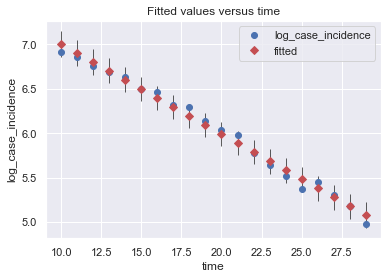

In [11]:
y, X = dmatrices('log_case_incidence ~ time', 
                 data = dataframe)
model = sma.OLS(y, X)
res = model.fit()
print(res.summary())
fig = sm.graphics.regressionplots.plot_fit(res, 1)
print(f"doublign time = {m.log(2)/res.params[1]}")

In [12]:
growth_rates = []
doubling_times = []
for _ in range(data.shape[0]):
    log_diff = infection_counts.iloc[_].diff(1).apply(lambda x: np.log(x))

    data_set_up = {
        "log_case_incidence": log_diff[10:20],
        "time": list(range(10, 20))
    }
    dataframe = pd.DataFrame(data_set_up)
    dataframe = pd.DataFrame(data_set_up)
    
    y, X = dmatrices('log_case_incidence ~ time', 
                     data = dataframe)
    model = sma.OLS(y, X)
    res = model.fit()
    growth_rates.append(res.params[1])

In [13]:
x = pd.Series(growth_rates) # 200 values
#x = x[x.between(x.quantile(.05), x.quantile(.95))] # without outliers

In [14]:
data_pars = data[data.columns[0:8]]
growth_rate_series = pd.Series(growth_rates)
data_pars["growth_rate"] = growth_rate_series
data_pars["two_step_tracing"] = data_pars["2_step_tracing"]

C:\Users\mfyles\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\mfyles\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Text(0.5, 1.0, 'Figures/Growth Rate distribution.png')

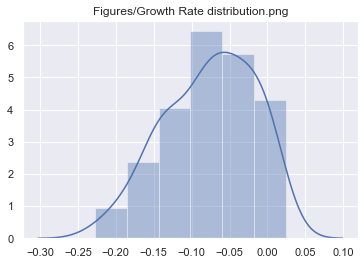

In [15]:
sns.distplot(x)
plt.title("Figures/Growth Rate distribution.png")

In [20]:
y, X = dmatrices('growth_rate ~ R_0 + contact_tracing_success_prob + infection_detect_prob + global_contact_reduction * I(prob_has_trace_app**3)', 
                 data = data_pars)
model_1 = sma.RLM(y, X)
res = model_1.fit()
print(res.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:            growth_rate   No. Observations:                  100
Model:                            RLM   Df Residuals:                       93
Method:                          IRLS   Df Model:                            6
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Fri, 01 May 2020                                         
Time:                        16:09:13                                         
No. Iterations:                    28                                         
                                                          coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------

## Residuals vs Fitted Value

Text(0, 0.5, 'Residual')

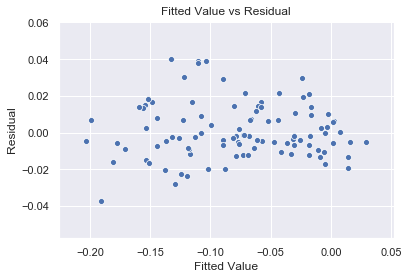

In [21]:
sns.scatterplot(res.fittedvalues, res.resid)
plt.title("Fitted Value vs Residual")
plt.xlabel("Fitted Value")
plt.ylabel("Residual")

This looks like strong heteroscedasticity to me, it's probably occurring from the way we calculate growth rates being much much unstable for exponentially decaying curves?

## Residual Dsitribution

Text(0.5, 1.0, 'Distribution of the residuals')

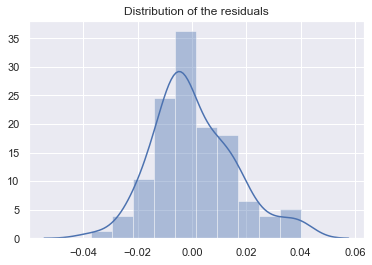

In [22]:
sns.distplot(res.resid)
plt.title("Distribution of the residuals")

Sort of normally distributed

## Normality of residuals tests

In [23]:
name = ['Jarque-Bera', 'Chi^2 two-tail prob.', 'Skew', 'Kurtosis']
test = sms.jarque_bera(res.resid)
lzip(name, test)

[('Jarque-Bera', 5.223319986400697),
 ('Chi^2 two-tail prob.', 0.07341257817944655),
 ('Skew', 0.530649825337213),
 ('Kurtosis', 3.35670695005075)]

## Heteroskedasticity tests

We have strong heteroscedasticity in our data

In [24]:
name = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']
test = sms.het_breuschpagan(res.resid, res.model.exog)
lzip(name, test)

[('Lagrange multiplier statistic', 11.021575066593925),
 ('p-value', 0.08771191319531609),
 ('f-value', 1.9199532207955259),
 ('f p-value', 0.08563938538940495)]